Fine-tuning CLIP

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import kagglehub
import os
import shutil
import glob

BASE_DIR = "/content/drive/MyDrive/clothing_dataset"
os.makedirs(BASE_DIR, exist_ok=True)
print("BASE_DIR:", BASE_DIR)


path = kagglehub.dataset_download("nirmalsankalana/fashion-product-text-images-dataset")
print("Raw downloaded path:", path)


DATA_DIR = BASE_DIR
IMG_DIR = os.path.join(DATA_DIR, "images")
os.makedirs(IMG_DIR, exist_ok=True)

print("Files in downloaded folder:")
for root, dirs, files in os.walk(path):
    for f in files[:10]:
        print(" ", os.path.join(root, f))

    break

BASE_DIR: /content/drive/MyDrive/clothing_dataset


100%|██████████| 3.17G/3.17G [00:38<00:00, 88.5MB/s]

Extracting files...


Raw downloaded path: /root/.cache/kagglehub/datasets/nirmalsankalana/fashion-product-text-images-dataset/versions/1
Files in downloaded folder:
  /root/.cache/kagglehub/datasets/nirmalsankalana/fashion-product-text-images-dataset/versions/1/data.csv


In [4]:

candidate_csvs = glob.glob(os.path.join(path, "**", "*.csv"), recursive=True)
print("Найденные csv:")
for c in candidate_csvs:
    print(" ", c)


if len(candidate_csvs) == 0:
    raise RuntimeError("Не нашёл .csv внутри датасета, нужно посмотреть структуру вручную.")
CSV_SRC = candidate_csvs[0]


CSV_PATH = os.path.join(DATA_DIR, "data.csv")
shutil.copy2(CSV_SRC, CSV_PATH)
print("CSV сохранён как:", CSV_PATH)


candidate_imgs = glob.glob(os.path.join(path, "**", "*.jpg"), recursive=True) \
                + glob.glob(os.path.join(path, "**", "*.jpeg"), recursive=True) \
                + glob.glob(os.path.join(path, "**", "*.png"), recursive=True)

print("Нашлось изображений:", len(candidate_imgs))


for img_src in candidate_imgs:
    img_name = os.path.basename(img_src)
    dst = os.path.join(IMG_DIR, img_name)
    if not os.path.exists(dst):
        shutil.copy2(img_src, dst)

print("Готово. Картинки скопированы в:", IMG_DIR)
print("Всего картинок теперь в IMG_DIR:", len(os.listdir(IMG_DIR)))


Найденные csv:
  /root/.cache/kagglehub/datasets/nirmalsankalana/fashion-product-text-images-dataset/versions/1/data.csv
CSV сохранён как: /content/drive/MyDrive/clothing_dataset/data.csv
Нашлось изображений: 44441
Готово. Картинки скопированы в: /content/drive/MyDrive/clothing_dataset/images
Всего картинок теперь в IMG_DIR: 44441


In [5]:
import os, random, json, math, time
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel, get_cosine_schedule_with_warmup


DATA_DIR = "/content/drive/MyDrive/clothing_dataset"
CSV_PATH = os.path.join(DATA_DIR, "/content/drive/MyDrive/clothing_dataset/data.csv")
IMG_DIR = os.path.join(DATA_DIR, "/content/drive/MyDrive/clothing_dataset/images")


OUT_DIR = "/content/drive/MyDrive/clip_clothing_ckpts"
os.makedirs(OUT_DIR, exist_ok=True)

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = True

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [7]:
df = pd.read_csv(CSV_PATH)


need_cols = ["image", "description"]
missing = [c for c in need_cols if c not in df.columns]
assert not missing, f"Нет столбцов: {missing} — проверь CSV"

df = df[need_cols].copy()
df["image"] = df["image"].astype(str).str.strip()
df["description"] = df["description"].astype(str).str.strip()

# пустые/NaN и дубликаты
df = df.replace({"": np.nan}).dropna(subset=need_cols)
df = df.drop_duplicates(subset=need_cols).reset_index(drop=True)

# фильтрация записи, где файла нет на диске
exists_mask = df["image"].apply(lambda fn: os.path.exists(os.path.join(IMG_DIR, fn)))
missing_count = (~exists_mask).sum()
if missing_count:
    print(f"отсутствуют файлы у {missing_count} строк — они будут удалены")
df = df[exists_mask].reset_index(drop=True)

print("Всего записей:", len(df))
df.head(3)

Всего записей: 44439


,image,description
0,3238.jpg,"Round toed, black sports shoes with red accent..."
1,43044.jpg,Style Note Built with the breathability and ze...
2,54018.jpg,Teal handbag that has stitch detailing with a...


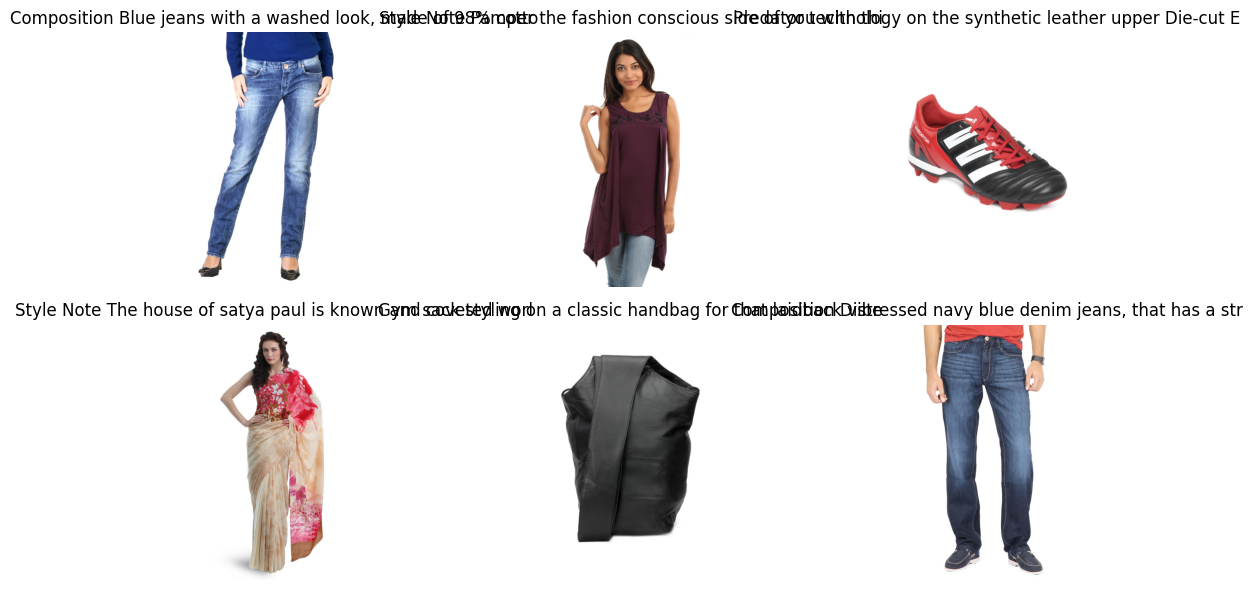

In [8]:
sample = df.sample(n=min(6, len(df)), random_state=SEED)
plt.figure(figsize=(12,6))
for i, (_, row) in enumerate(sample.iterrows(), start=1):
    img = Image.open(os.path.join(IMG_DIR, row["image"])).convert("RGB")
    plt.subplot(2,3,i); plt.imshow(img); plt.axis("off")
    plt.title(row["description"][:60])
plt.tight_layout(); plt.show()

In [9]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df, test_size=0.10, random_state=SEED, shuffle=True
)
len(train_df), len(val_df)

(39995, 4444)

In [11]:
from transformers import CLIPModel, CLIPProcessor

MODEL_NAME = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(MODEL_NAME)
model = CLIPModel.from_pretrained(MODEL_NAME)

model = model.to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [13]:

class ClothingClipDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(os.path.join(self.img_dir, row["image"])).convert("RGB")
        txt = row["description"]
        return {"image": img, "text": txt}


def make_collate(processor):
    def collate(batch):
        imgs = [b["image"] for b in batch]
        txts = [b["text"]  for b in batch]
        enc = processor(
            text=txts,
            images=imgs,
            return_tensors="pt",
            truncation=True,
            padding=True,
        )
        return enc
    return collate


BATCH_SIZE   = 64
NUM_WORKERS  = 2
PIN_MEMORY   = True


train_loader = DataLoader(
    ClothingClipDataset(train_df, IMG_DIR),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    collate_fn=make_collate(processor),
    persistent_workers=NUM_WORKERS > 0,
)

val_loader = DataLoader(
    ClothingClipDataset(val_df, IMG_DIR),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    collate_fn=make_collate(processor),
    persistent_workers=NUM_WORKERS > 0,
)

batch = next(iter(train_loader))
print({k: v.shape for k, v in batch.items()})


{'pixel_values': torch.Size([64, 3, 224, 224]), 'input_ids': torch.Size([64, 77]), 'attention_mask': torch.Size([64, 77])}


In [15]:
model.eval()
device = next(model.parameters()).device

def batch_clip_score(logits_per_image: torch.Tensor) -> float:
    with torch.no_grad():
        return (torch.diag(logits_per_image).mean() * 100.0).item()

n_batches = 3
scores = []

with torch.no_grad():
    it = iter(val_loader)
    for b in range(n_batches):
        try:
            batch = next(it)
        except StopIteration:
            break
        batch = {k: v.to(device) for k, v in batch.items()}
        out = model(**batch)
        s = batch_clip_score(out.logits_per_image)
        scores.append(s)
        print(f"Batch {b+1}: CLIP score (diag mean) = {s:.2f}")

print(f"\nСредний CLIP score по {len(scores)} батчам: {np.mean(scores):.2f}")


Batch 1: CLIP score (diag mean) = 3029.90
Batch 2: CLIP score (diag mean) = 3050.19
Batch 3: CLIP score (diag mean) = 2990.69

Средний CLIP score по 3 батчам: 3023.60


/tmp/ipython-input-3111412906.py:72: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)
Epoch 1/4:   0%|          | 0/625 [00:00<?, ?it/s]/tmp/ipython-input-3111412906.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 1/4: 100%|██████████| 625/625 [26:17<00:00,  2.52s/it, train_loss=0.5835, train_clip=2948.91]



Epoch 1: train_loss=0.5835 | train_clip=2948.91 | val_loss=0.4396 | val_clip=2982.88
[CKPT] saved epoch 01 → /content/drive/MyDrive/clip_clothing_ckpts/epoch_01
       files: config.json, merges.txt, model.safetensors, preprocessor_config.json, special_tokens_map.json, tokenizer.json, tokenizer_config.json, vocab.json
[BEST] updated at /content/drive/MyDrive/clip_clothing_ckpts/best (val_clip=2982.88)
          files: config.json, merges.txt, model.safetensors, preprocessor_config.json, special_tokens_map.json, tokenizer.json, tokenizer_config.json, vocab.json


Epoch 2/4: 100%|██████████| 625/625 [24:12<00:00,  2.32s/it, train_loss=0.3135, train_clip=3070.85]



Epoch 2: train_loss=0.3135 | train_clip=3070.85 | val_loss=0.3528 | val_clip=3083.54
[CKPT] saved epoch 02 → /content/drive/MyDrive/clip_clothing_ckpts/epoch_02
       files: config.json, merges.txt, model.safetensors, preprocessor_config.json, special_tokens_map.json, tokenizer.json, tokenizer_config.json, vocab.json
[BEST] updated at /content/drive/MyDrive/clip_clothing_ckpts/best (val_clip=3083.54)
          files: config.json, merges.txt, model.safetensors, preprocessor_config.json, special_tokens_map.json, tokenizer.json, tokenizer_config.json, vocab.json


Epoch 3/4: 100%|██████████| 625/625 [24:26<00:00,  2.35s/it, train_loss=0.1684, train_clip=3223.65]



Epoch 3: train_loss=0.1684 | train_clip=3223.65 | val_loss=0.3281 | val_clip=3187.49
[CKPT] saved epoch 03 → /content/drive/MyDrive/clip_clothing_ckpts/epoch_03
       files: config.json, merges.txt, model.safetensors, preprocessor_config.json, special_tokens_map.json, tokenizer.json, tokenizer_config.json, vocab.json
[BEST] updated at /content/drive/MyDrive/clip_clothing_ckpts/best (val_clip=3187.49)
          files: config.json, merges.txt, model.safetensors, preprocessor_config.json, special_tokens_map.json, tokenizer.json, tokenizer_config.json, vocab.json


Epoch 4/4: 100%|██████████| 625/625 [29:07<00:00,  2.80s/it, train_loss=0.1072, train_clip=3354.10]



Epoch 4: train_loss=0.1072 | train_clip=3354.10 | val_loss=0.3269 | val_clip=3218.69
[CKPT] saved epoch 04 → /content/drive/MyDrive/clip_clothing_ckpts/epoch_04
       files: config.json, merges.txt, model.safetensors, preprocessor_config.json, special_tokens_map.json, tokenizer.json, tokenizer_config.json, vocab.json
[BEST] updated at /content/drive/MyDrive/clip_clothing_ckpts/best (val_clip=3218.69)
          files: config.json, merges.txt, model.safetensors, preprocessor_config.json, special_tokens_map.json, tokenizer.json, tokenizer_config.json, vocab.json

===== CHECKPOINTS (with sizes) =====
    best | /content/drive/MyDrive/clip_clothing_ckpts/best
          config.json (1.2KB), merges.txt (512.3KB), model.safetensors (577.1MB), preprocessor_config.json (504.0B), special_tokens_map.json (588.0B), tokenizer.json (3.5MB), tokenizer_config.json (774.0B), vocab.json (842.1KB)
epoch_01 | /content/drive/MyDrive/clip_clothing_ckpts/epoch_01
          config.json (1.2KB), merges.txt (5

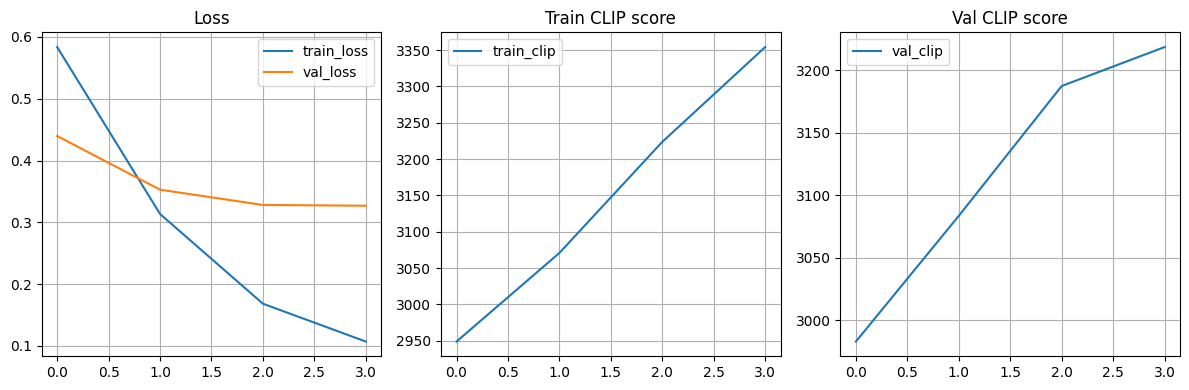

Цель: средний CLIP score > 30. Финальный val_clip: 3218.69


In [16]:

import os, json, math, numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import get_cosine_schedule_with_warmup


OUT_DIR = "/content/drive/MyDrive/clip_clothing_ckpts"
os.makedirs(OUT_DIR, exist_ok=True)


EPOCHS = 4
LR = 1e-5
WEIGHT_DECAY = 0.01
GRAD_NORM_CLIP = 1.0
USE_AMP = (device == "cuda")
PRINT_EVERY = 50


def batch_clip_score(logits_per_image: torch.Tensor) -> float:
    with torch.no_grad():
        return (torch.diag(logits_per_image).mean() * 100.0).item()

def clip_contrastive_loss(logits_per_image, logits_per_text):
    bsz = logits_per_image.size(0)
    targets = torch.arange(bsz, device=logits_per_image.device)
    loss_i = F.cross_entropy(logits_per_image, targets)
    loss_t = F.cross_entropy(logits_per_text, targets)
    return (loss_i + loss_t) * 0.5

@torch.no_grad()
def validate(model, loader):
    model.eval()
    loss_list, score_list = [], []
    for batch in tqdm(loader, desc="Valid", leave=False):
        batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
        out = model(**batch)
        loss = clip_contrastive_loss(out.logits_per_image, out.logits_per_text)
        loss_list.append(loss.item())
        score_list.append(batch_clip_score(out.logits_per_image))
    return float(np.mean(loss_list)), float(np.mean(score_list))

def human(n):
    for u in ["B","KB","MB","GB","TB"]:
        if n < 1024: return f"{n:.1f}{u}"
        n /= 1024
    return f"{n:.1f}PB"

def list_checkpoints_with_sizes(out_dir: str):
    rows = []
    for name in sorted(os.listdir(out_dir)):
        path = os.path.join(out_dir, name)
        if os.path.isdir(path) and (name.startswith("epoch_") or name == "best"):
            file_list = []
            for f in sorted(os.listdir(path)):
                size = os.path.getsize(os.path.join(path, f))
                file_list.append(f"{f} ({human(size)})")
            rows.append((name, path, ", ".join(file_list)))
    return rows


optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * EPOCHS
warmup_steps = max(1, int(0.1 * total_steps))
scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


history = {"train_loss": [], "train_clip": [], "val_loss": [], "val_clip": []}
best_val_clip = -1e9

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss, running_clip = 0.0, 0.0

    pbar = tqdm(enumerate(train_loader, 1), total=len(train_loader), desc=f"Epoch {epoch}/{EPOCHS}")
    for step, batch in pbar:
        batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=USE_AMP):
            out = model(**batch)
            loss = clip_contrastive_loss(out.logits_per_image, out.logits_per_text)

        scaler.scale(loss).backward()

        if GRAD_NORM_CLIP is not None:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_NORM_CLIP)

        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        # логирование батча
        running_loss += loss.item()
        with torch.no_grad():
            running_clip += batch_clip_score(out.logits_per_image)

        if step % PRINT_EVERY == 0 or step == len(train_loader):
            avg_loss = running_loss / step
            avg_clip = running_clip / step
            pbar.set_postfix({"train_loss": f"{avg_loss:.4f}", "train_clip": f"{avg_clip:.2f}"})

    # валидация
    val_loss, val_clip = validate(model, val_loader)


    history["train_loss"].append(running_loss / len(train_loader))
    history["train_clip"].append(running_clip / len(train_loader))
    history["val_loss"].append(val_loss)
    history["val_clip"].append(val_clip)

    print(f"\nEpoch {epoch}: "
          f"train_loss={history['train_loss'][-1]:.4f} | "
          f"train_clip={history['train_clip'][-1]:.2f} | "
          f"val_loss={val_loss:.4f} | val_clip={val_clip:.2f}")

    # чекпоинт эпохи
    ckpt_dir = os.path.join(OUT_DIR, f"epoch_{epoch:02d}")
    os.makedirs(ckpt_dir, exist_ok=True)
    model.save_pretrained(ckpt_dir)
    processor.save_pretrained(ckpt_dir)
    files = ", ".join(sorted(os.listdir(ckpt_dir)))
    print(f"[CKPT] saved epoch {epoch:02d} → {ckpt_dir}")
    print(f"       files: {files}")

    # лучший чекпоинт по val_clip
    if val_clip > best_val_clip:
        best_val_clip = val_clip
        best_dir = os.path.join(OUT_DIR, "best")
        model.save_pretrained(best_dir)
        processor.save_pretrained(best_dir)
        best_files = ", ".join(sorted(os.listdir(best_dir)))
        print(f"[BEST] updated at {best_dir} (val_clip={val_clip:.2f})")
        print(f"          files: {best_files}")


with open(os.path.join(OUT_DIR, "history.json"), "w") as f:
    json.dump(history, f, indent=2)

# сводка по чекпоинтам
rows = list_checkpoints_with_sizes(OUT_DIR)
print("\n===== CHECKPOINTS (with sizes) =====")
for name, path, files in rows:
    print(f"{name:>8} | {path}")
    print(f"          {files}")
print("====================================")

# графики
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.title("Loss"); plt.legend(); plt.grid(True)

plt.subplot(1,3,2)
plt.plot(history["train_clip"], label="train_clip")
plt.title("Train CLIP score"); plt.legend(); plt.grid(True)

plt.subplot(1,3,3)
plt.plot(history["val_clip"], label="val_clip")
plt.title("Val CLIP score"); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

print(f"Цель: средний CLIP score > 30. "
      f"Финальный val_clip: {history['val_clip'][-1]:.2f}")

In [17]:
import torch, numpy as np, torch.nn.functional as F

@torch.no_grad()
def cosine_clip_score(model, loader, device):
    model.eval()
    scores = []
    for batch in loader:
        px = batch["pixel_values"].to(device)
        ids = batch["input_ids"].to(device)
        attn = batch["attention_mask"].to(device)

        img_f = F.normalize(model.get_image_features(pixel_values=px), dim=-1)
        txt_f = F.normalize(model.get_text_features(input_ids=ids, attention_mask=attn), dim=-1)
        cos = img_f @ txt_f.t()                   # [-1..1]
        scores.append(torch.diag(cos).mean().item()*100)
    return float(np.mean(scores))

val_cos = cosine_clip_score(model, val_loader, device)
print(f"Средний cosine CLIP score (0-100): {val_cos:.2f}")


Средний cosine CLIP score (0-100): 32.23


Реализация системы поиска товаров

In [18]:
import os, torch
from transformers import CLIPModel, CLIPProcessor

device = "cuda" if torch.cuda.is_available() else "cpu"

OUT_DIR = "/content/drive/MyDrive/clip_clothing_ckpts"
BEST_DIR = os.path.join(OUT_DIR, "best")

processor = CLIPProcessor.from_pretrained(BEST_DIR)
model = CLIPModel.from_pretrained(BEST_DIR).to(device).eval()

print("Модель и процессор загружены из:", BEST_DIR)

Модель и процессор загружены из: /content/drive/MyDrive/clip_clothing_ckpts/best


In [19]:
import numpy as np
import json
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm

DATA_DIR = "/content/drive/MyDrive/clothing_dataset"
CSV_PATH = os.path.join(DATA_DIR, "data.csv")
IMG_DIR  = os.path.join(DATA_DIR, "images")

import pandas as pd
df_full = pd.read_csv(CSV_PATH)
df_full = df_full[["image","description"]].dropna().reset_index(drop=True)

class AllImagesDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = Image.open(os.path.join(self.img_dir, row["image"])).convert("RGB")
        return {"image": img, "image_name": row["image"]}

def make_collate(processor):
    def collate(batch):
        imgs = [b["image"] for b in batch]
        enc = processor(images=imgs, return_tensors="pt")
        enc["image_name"] = [b["image_name"] for b in batch]
        return enc
    return collate

full_loader = DataLoader(
    AllImagesDataset(df_full, IMG_DIR),
    batch_size=64, shuffle=False, num_workers=2, pin_memory=True,
    collate_fn=make_collate(processor), persistent_workers=True
)


IMG_EMB_PATH   = os.path.join(OUT_DIR, "image_embeddings.npy")
IMG_NAMES_PATH = os.path.join(OUT_DIR, "image_names.json")

all_embs, all_names = [], []
model.eval()
with torch.no_grad():
    for batch in tqdm(full_loader, desc="Encoding images"):
        px = batch["pixel_values"].to(device, non_blocking=True)
        feats = model.get_image_features(pixel_values=px)
        feats = F.normalize(feats, dim=-1)
        all_embs.append(feats.cpu().float().numpy())
        all_names.extend(batch["image_name"])

img_emb = np.concatenate(all_embs, axis=0).astype("float32")
np.save(IMG_EMB_PATH, img_emb)
with open(IMG_NAMES_PATH, "w") as f:
    json.dump(all_names, f)

print("Сохранены эмбеддинги:", IMG_EMB_PATH, img_emb.shape)
print("Сохранены имена файлов:", IMG_NAMES_PATH, len(all_names))

Encoding images: 100%|██████████| 690/690 [25:16<00:00,  2.20s/it]


Сохранены эмбеддинги: /content/drive/MyDrive/clip_clothing_ckpts/image_embeddings.npy (44160, 512)
Сохранены имена файлов: /content/drive/MyDrive/clip_clothing_ckpts/image_names.json 44160


In [20]:
!pip -q install faiss-cpu
import faiss, os

FAISS_PATH = os.path.join(OUT_DIR, "faiss.index")

d = img_emb.shape[1]
index = faiss.IndexFlatIP(d)
index.add(img_emb)
faiss.write_index(index, FAISS_PATH)

print("FAISS-индекс готов:", FAISS_PATH, "| векторов:", index.ntotal)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 22.7 MB/s eta 0:00:00
FAISS-индекс готов: /content/drive/MyDrive/clip_clothing_ckpts/faiss.index | векторов: 44160


In [21]:
import matplotlib.pyplot as plt

_img_emb = np.load(IMG_EMB_PATH)
with open(IMG_NAMES_PATH, "r") as f:
    _img_names = json.load(f)

_use_faiss = os.path.exists(FAISS_PATH)
if _use_faiss:
    _index = faiss.read_index(FAISS_PATH)

import torch.nn.functional as F

@torch.no_grad()
def encode_text(query: str):
    enc = processor(text=[query], return_tensors="pt", padding=True, truncation=True)
    enc = {k: v.to(device) for k, v in enc.items()}
    feat = model.get_text_features(**enc)
    feat = F.normalize(feat, dim=-1)
    return feat.cpu().float().numpy()

def search_products(model, df_all, query: str, top_k: int = 6):
    """
    model
    df_all
    query
    top_k

    Возвращает: список (image_name, score)
    """
    q = encode_text(query)

    if _use_faiss:
        D, I = _index.search(q, top_k)
        scores, idxs = D[0], I[0]
    else:
        scores_all = (_img_emb @ q[0]).astype("float32")
        idxs = np.argsort(-scores_all)[:top_k]
        scores = scores_all[idxs]

    results = [(_img_names[i], float(scores[j])) for j, i in enumerate(idxs)]
    return results

def show_results(results, ncols=6, title=""):
    n = len(results)
    ncols = min(ncols, n)
    nrows = (n + ncols - 1) // ncols
    plt.figure(figsize=(3*ncols, 3*nrows))
    for i, (name, score) in enumerate(results, 1):
        img = Image.open(os.path.join(IMG_DIR, name)).convert("RGB")
        plt.subplot(nrows, ncols, i)
        plt.imshow(img); plt.axis("off")
        plt.title(f"{name}\nscore={score:.3f}", fontsize=9)
    if title: plt.suptitle(title)
    plt.tight_layout(); plt.show()


red skirt → ['13305.jpg', '13304.jpg', '5005.jpg', '25931.jpg', '33271.jpg', '39314.jpg', '42290.jpg', '46814.jpg']


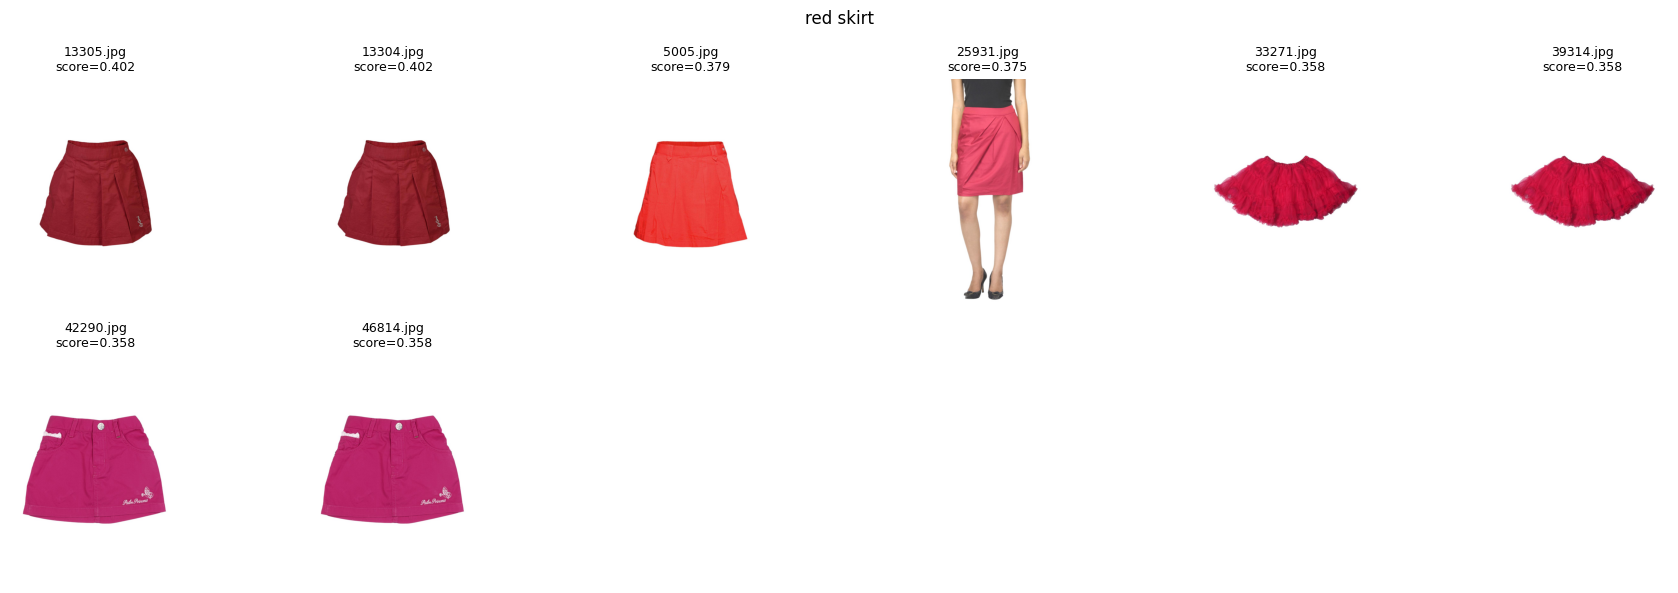

blue sunglasses → ['17221.jpg', '17227.jpg', '17224.jpg', '17222.jpg', '16836.jpg', '17229.jpg', '16894.jpg', '17226.jpg']


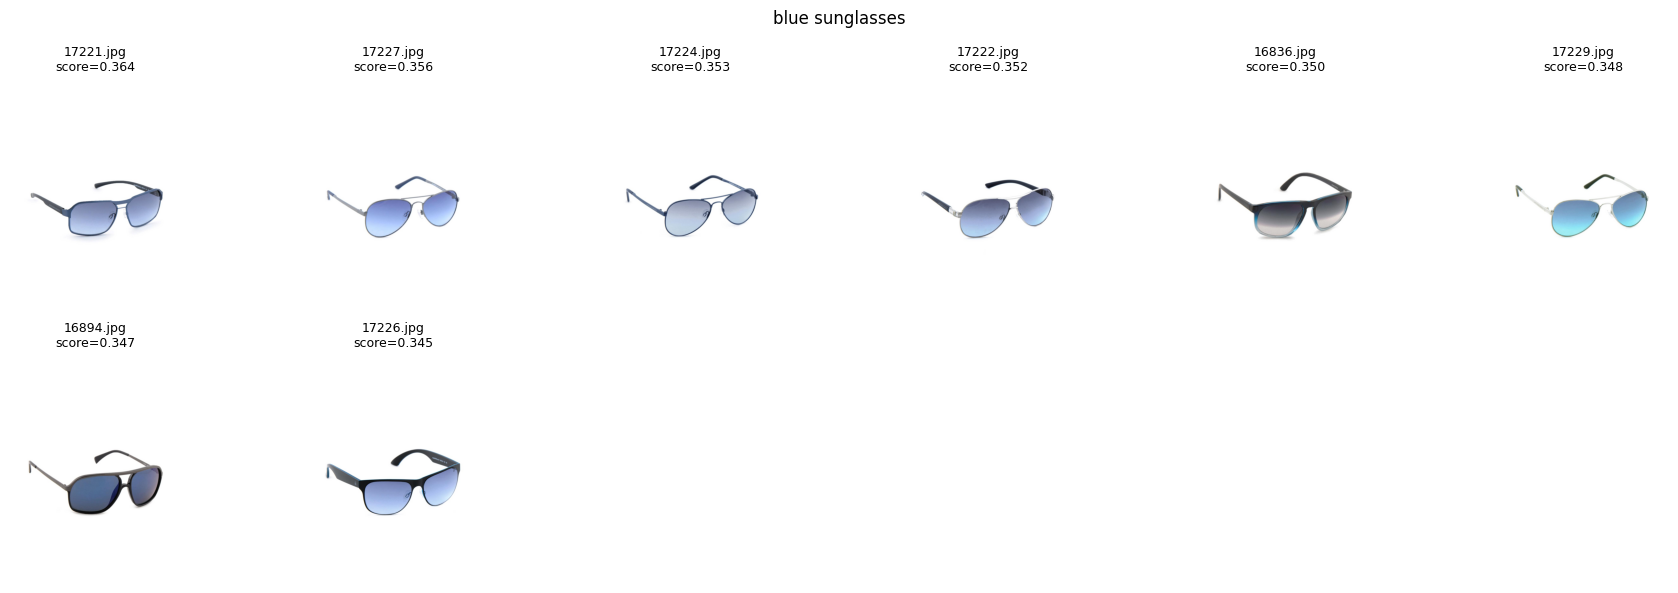

mickey mouse → ['4377.jpg', '7288.jpg', '4205.jpg', '4210.jpg', '11359.jpg', '4435.jpg', '5183.jpg', '39863.jpg']


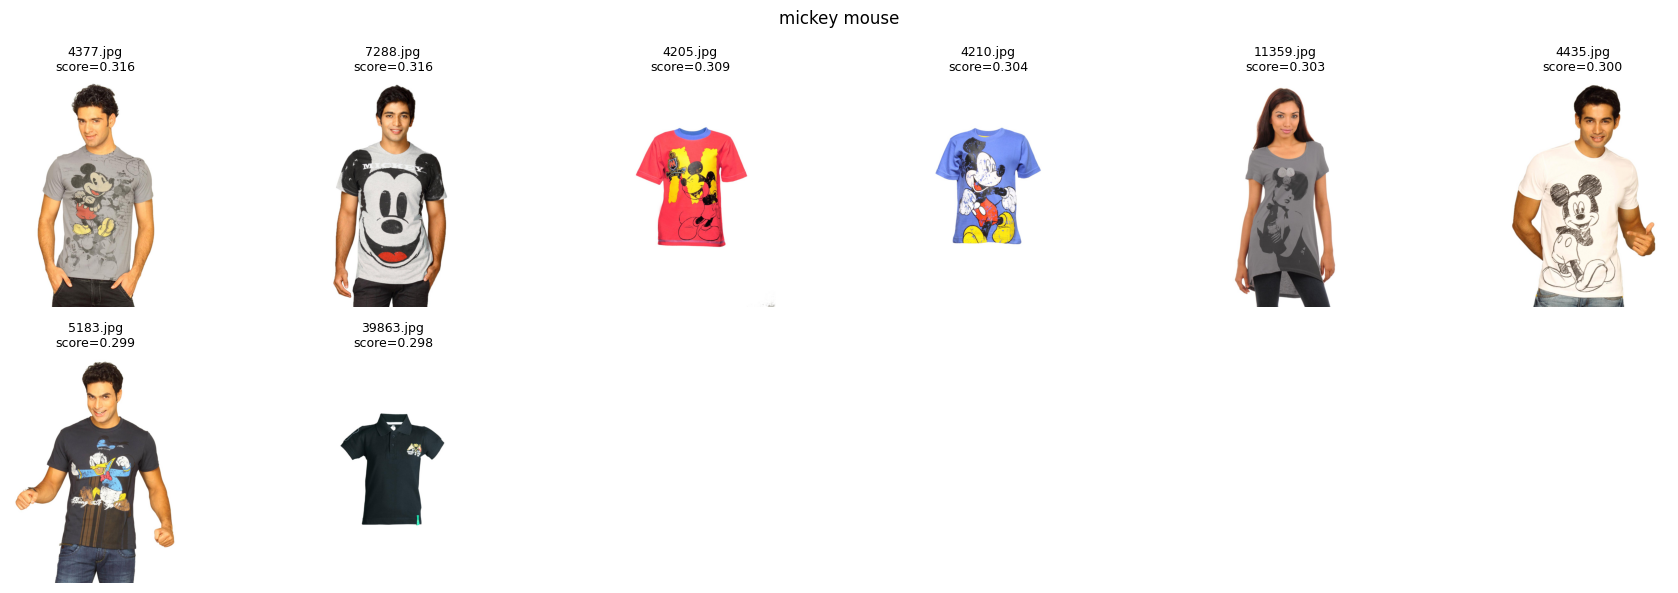

leather jacket → ['59106.jpg', '59133.jpg', '19340.jpg', '18726.jpg', '38155.jpg', '59128.jpg', '27890.jpg', '17911.jpg']


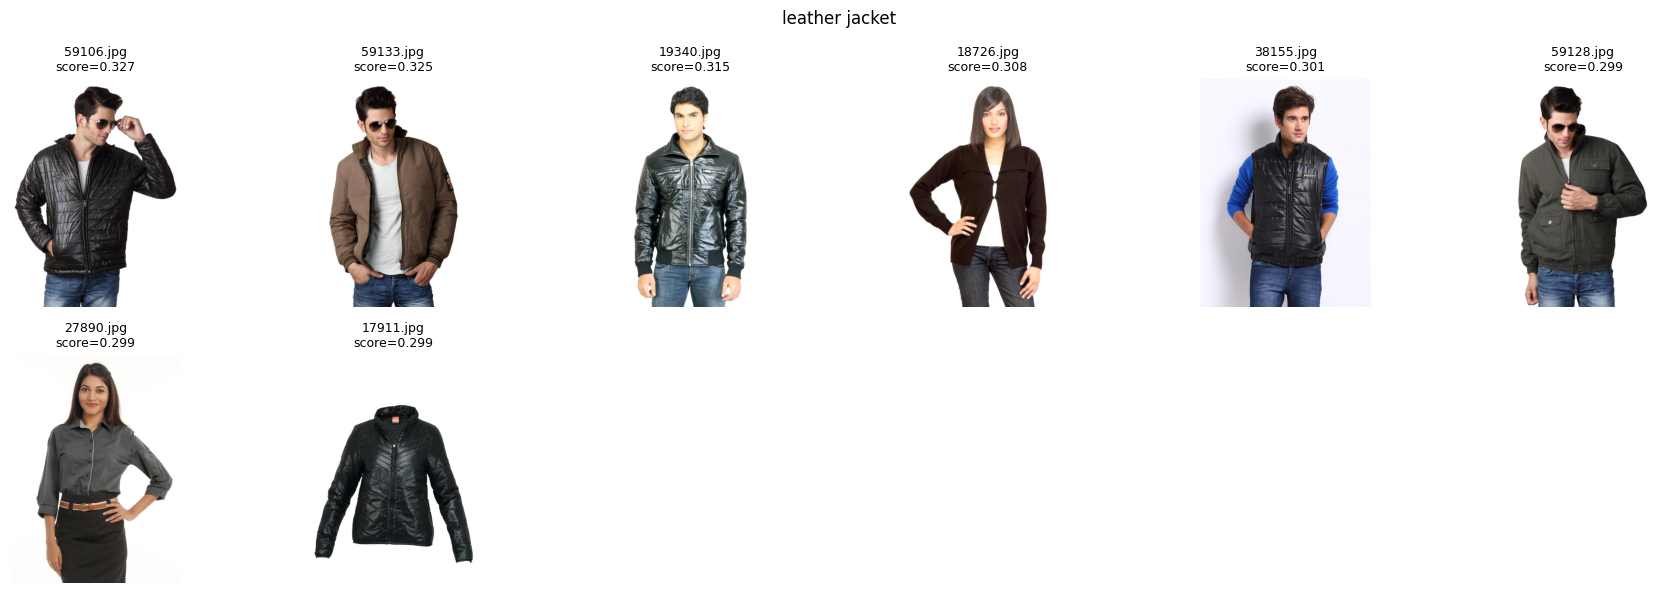

white running shoes → ['5392.jpg', '5042.jpg', '1618.jpg', '3689.jpg', '39684.jpg', '39683.jpg', '5366.jpg', '3661.jpg']


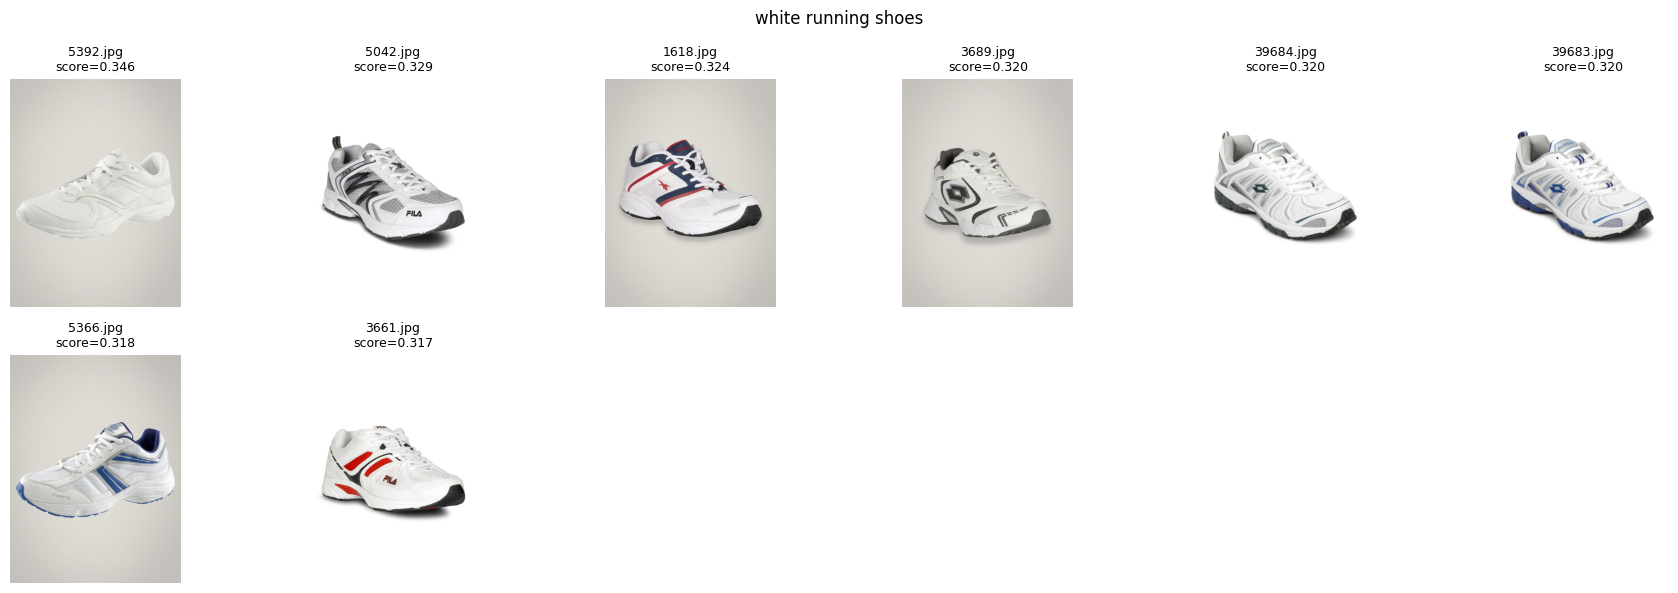

In [22]:
queries = ["red skirt", "blue sunglasses", "mickey mouse", "leather jacket", "white running shoes"]

for q in queries:
    res = search_products(model, df_full, q, top_k=8)
    print(q, "→", [r[0] for r in res])
    show_results(res, title=q)
